# Setup

In [1]:
#%pip install einops transformers sae_lens sae_vis
import einops
import os
from transformers import AutoModel, AutoTokenizer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes, convert_connor_rob_sae_to_our_saelens_format, download_sae_from_hf
import numpy as np
import torch as t
import plotly_express as px
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
from scipy import stats
from torch.utils.data import Dataset
from sae_vis.model_fns import AutoEncoderConfig, AutoEncoder
from transformer_lens import utils as tl_utils
from transformer_lens.hook_points import (
    HookPoint,
)

from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.utils import (
    load_dataset,
    tokenize_and_concatenate,
    download_file_from_hf,
)

from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
device = t.device("cuda" if t.cuda.is_available() else "cpu")
from transformer_lens import HookedSAE, HookedSAEConfig
from transformer_lens.utils import download_file_from_hf


from importlib import reload
from utils.autoencoder import AutoEncoder
import matplotlib as mpl
cmap = mpl.colormaps["Spectral"]

from utils import SAE_metrics
from utils import vector_metrics
from utils import utils 


import torch 
reload(utils)
reload(SAE_metrics)
reload(vector_metrics)


/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-05-23 13:07:23.731928: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 13:07:23.776000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

<module 'utils.vector_metrics' from '/home/ubuntu/brianna-chrisman/MATS-2024/utils/vector_metrics.py'>

# Load SAE & Model

In [2]:
auto_encoder_run = "concat-z-gelu-21-l1-lr-sweep-3/gelu-2l_L1_Hcat_z_lr1.00e-03_l12.00e+00_ds16384_bs4096_dc1.00e-07_rie50000_nr4_v78"
sae = AutoEncoder.load_from_hf(auto_encoder_run)
model = HookedTransformer.from_pretrained("gelu-2l").to(device)

{'act_name': 'blocks.1.attn.hook_z',
 'act_size': 512,
 'anthropic_resample_last': 25000,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'concat_heads': True,
 'dead_direction_cutoff': 1e-07,
 'device': 'cuda',
 'dict_mult': 32,
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'head': 'cat',
 'l1_coeff': 2.0,
 'layer': 1,
 'lr': 0.001,
 'model_batch_size': 512,
 'model_name': 'gelu-2l',
 'name': 'gelu-2l_1_16384_z',
 'num_resamples': 4,
 'num_tokens': 2000000000,
 're_init_every': 50000,
 'reinit': 'reinit',
 'resample_factor': 0.01,
 'save_state_dict_every': 50000,
 'seed': 49,
 'seq_len': 128,
 'site': 'z',
 'wandb_entity': 'ckkissane',
 'wandb_project_name': 'concat-z-gelu-21-l1-lr-sweep-3'}
Loaded pretrained model gelu-2l into HookedTransformer
Moving model to device:  cuda


In [3]:
# Split tensor into 8 equal parts
W_dec_splits = torch.split(sae.W_dec, model.cfg.d_head, dim=1)
# Turn list of tensors into a single tensor, add dimension
W_dec_splits = torch.stack(W_dec_splits, dim=0)
contributions = W_dec_splits.norm(dim=2)
contributions = contributions/contributions.sum(dim=0, keepdim=True)
contributions

tensor([[0.1365, 0.1563, 0.1192,  ..., 0.1673, 0.0468, 0.1531],
        [0.0560, 0.3308, 0.1041,  ..., 0.0830, 0.0554, 0.1194],
        [0.4276, 0.0736, 0.1790,  ..., 0.1209, 0.0434, 0.1782],
        ...,
        [0.0874, 0.0992, 0.1020,  ..., 0.0821, 0.0469, 0.1132],
        [0.0224, 0.0681, 0.0429,  ..., 0.0153, 0.6039, 0.0863],
        [0.1716, 0.0837, 0.1612,  ..., 0.4079, 0.0374, 0.1248]],
       device='cuda:0')

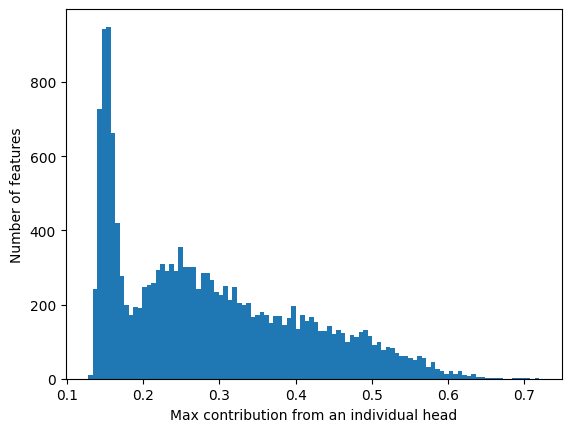

In [123]:
plt.hist(contributions.max(dim=0).values.cpu().detach().numpy(), bins=100)
plt.xlabel('Max contribution from an individual head')
plt.ylabel('Number of features')
plt.show()

In [59]:
# Load Pile data
data = load_dataset("NeelNanda/pile-10k", split="train[:1000]")
tokenized_data = tokenize_and_concatenate(data, model.tokenizer, max_length=32)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"][:1024]

dataset = utils.TokenDataset(all_tokens)
del tokenized_data, data, all_tokens

Map (num_proc=10):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [60]:
# Load LLM and SAE
model = HookedTransformer.from_pretrained("gelu-2l").to(device)
#hook_points = [h.replace('attn.hook_z', 'hook_resid_pre') for h in gpt2_sae.keys()]

Loaded pretrained model gelu-2l into HookedTransformer
Moving model to device:  cuda


In [151]:
_, _, acts, _ , _ = sae.forward(t.rand(sae.W_enc.shape[0]).to(device))
acts2 = t.rand(sae.W_enc.shape[0]).to(device) @ sae.W_enc + sae.b_enc
print((acts>0).float().mean())
print((acts2>0).float().mean())


tensor(0.0059, device='cuda:0')
tensor(0.0402, device='cuda:0')


In [156]:
sae.b_enc.shape

torch.Size([16384])

# Look at Activation Contributions

In [159]:
sae.b_dec.shape

torch.Size([512])

In [180]:
# We make a tensor to store the induction score for each head. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
induction_score_store = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)
W_enc_split = torch.split(sae.W_enc, model.cfg.d_head, dim=0)
W_enc_split = torch.stack(W_enc_split, dim=1)

b_dec_split = torch.split(sae.b_dec, model.cfg.d_head, dim=0)
b_dec_split = torch.stack(b_dec_split, dim=1).transpose(0,1)
# Append 
contributions_all = []

def SAE_hook(
    activations, #: torch.float[torch.Tensor, "batch seq_len n_head d_head "],
    hook: HookPoint,
):
    dot_prods = einops.einsum(W_enc_split, activations-b_dec_split,
                  "d_head n_head n_features, batch seq_len n_head d_head -> batch seq_len n_head n_features")
    (dot_prods.sum(dim=2, keepdim=True)+sae.b_enc)>0

    dot_prods[torch.where((dot_prods.sum(dim=2, keepdim=True)+ sae.b_enc)<0)] = torch.nan

    # Append contributions to contributons_all tensor
    contributions_all.append(dot_prods.to('cpu'))#.sum(dim=0).sum(dim=1))


for tokens, i in DataLoader(dataset, batch_size=64, shuffle=True):
    model.run_with_hooks(
        tokens, 
        return_type=None, # For efficiency, we don't need to calculate the logits
        fwd_hooks=[(
            sae.cfg["act_name"],
            SAE_hook
        )]
    )


IndexError: The shape of the mask [64, 32, 1, 16384] at index 2 does not match the shape of the indexed tensor [64, 32, 8, 16384] at index 2

In [172]:
contributions_all = torch.cat(contributions_all, dim=0)
contributions_all = einops.rearrange(contributions_all, "batch seq_len n_head n_features -> (batch seq_len) n_head n_features")
contributions_all.shape

torch.Size([32768, 8, 16384])

In [173]:
contributions_all.isnan().float().mean()

tensor(0.1249)

In [113]:
normed = (contributions_all**2).sum(dim=0)
normed = normed/normed.sum(dim=0, keepdim=True)
normed.shape

torch.Size([8, 16384])

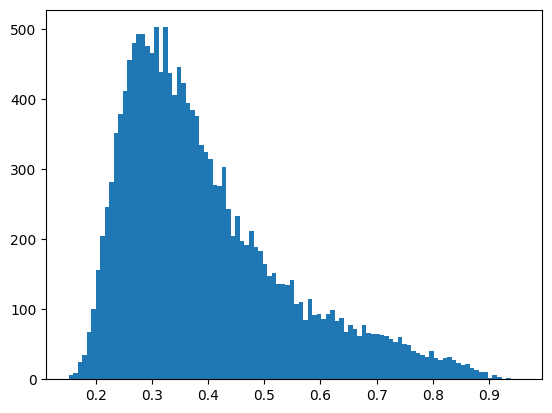

In [118]:
plt.hist(normed.max(dim=0).values, bins=100)
plt.show()

In [94]:
a = einops.rearrange(contributions_all, "batch seq_len n_head n_features -> (batch seq_len) n_head n_features")


In [98]:
a[:,:,1]

tensor([[ 0.1063,  0.4432, -0.0684,  ...,  0.1140, -0.0341,  0.1621],
        [ 0.0825,  0.4626, -0.0491,  ...,  0.1035, -0.0362,  0.1679],
        [-0.0049,  0.6636, -0.2342,  ...,  0.0864, -0.0504,  0.1618],
        ...,
        [ 0.3586,  1.2482, -0.2915,  ..., -0.8665, -0.2243,  0.5441],
        [ 0.5252,  1.8118, -0.4020,  ..., -1.5610, -0.2407,  0.7289],
        [ 0.4821,  0.7107, -0.2438,  ..., -0.0389, -0.1549,  0.5067]])

In [93]:
contributions_all.max()

tensor([[[[ 2.5598e-01,  1.0626e-01,  2.2022e-01,  ...,  5.2214e-01,
           -8.1074e-02,  1.3789e-01],
          [-1.8468e-01,  4.4324e-01,  3.9775e-01,  ..., -5.6378e-01,
            2.4357e-02, -1.4211e-01],
          [ 2.7656e-01, -6.8393e-02, -7.2752e-02,  ...,  1.7196e-01,
            3.9732e-01,  1.8549e-01],
          ...,
          [ 2.2754e-01,  1.1399e-01,  6.6205e-02,  ..., -2.1901e-01,
            1.9454e-01,  1.5027e-01],
          [-1.9198e-01, -3.4131e-02, -1.2947e-01,  ..., -1.7822e-02,
            2.0792e-01, -6.8057e-02],
          [ 2.4169e-01,  1.6212e-01,  2.8259e-01,  ...,  5.5884e-01,
            2.0451e-01,  3.3795e-01]],

         [[ 3.4018e-01,  8.2544e-02,  2.2621e-01,  ...,  4.1745e-01,
           -8.3391e-03,  1.5352e-01],
          [-2.4335e-01,  4.6264e-01,  3.1731e-01,  ..., -6.7297e-01,
            6.6912e-02, -8.3786e-02],
          [-1.4347e-01, -4.9074e-02,  7.4916e-02,  ...,  1.6964e-01,
            1.9603e-01,  3.7283e-01],
          ...,
     

In [78]:
contributions_all[0].shape

torch.Size([10, 64, 64, 16384])

In [18]:
sae.cfg["act_name"]

'blocks.1.attn.hook_z'

In [17]:
model.hook_points()

<bound method HookedRootModule.hook_points of HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint(

# Load Connor's SAEs

In [3]:

auto_encoder_runs = [
    "gpt2-small_L0_Hcat_z_lr1.20e-03_l11.80e+00_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L1_Hcat_z_lr1.20e-03_l18.00e-01_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v5",
    "gpt2-small_L2_Hcat_z_lr1.20e-03_l11.00e+00_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v4",
    "gpt2-small_L3_Hcat_z_lr1.20e-03_l19.00e-01_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L4_Hcat_z_lr1.20e-03_l11.10e+00_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v7",
    "gpt2-small_L5_Hcat_z_lr1.20e-03_l11.00e+00_ds49152_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L6_Hcat_z_lr1.20e-03_l11.10e+00_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L7_Hcat_z_lr1.20e-03_l11.10e+00_ds49152_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L8_Hcat_z_lr1.20e-03_l11.30e+00_ds24576_bs4096_dc1.00e-05_rsanthropic_rie25000_nr4_v6",
    "gpt2-small_L9_Hcat_z_lr1.20e-03_l11.20e+00_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L10_Hcat_z_lr1.20e-03_l11.30e+00_ds24576_bs4096_dc1.00e-05_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L11_Hcat_z_lr1.20e-03_l13.00e+00_ds24576_bs4096_dc3.16e-06_rsanthropic_rie25000_nr4_v9",
][:2]

hf_repo = "ckkissane/attn-saes-gpt2-small-all-layers"

gpt2_sae = {}
for auto_encoder_run in auto_encoder_runs:
    attn_sae_cfg = download_file_from_hf(hf_repo, f"{auto_encoder_run}_cfg.json")
    cfg = utils.AttnToHookedCfg(attn_sae_cfg)

    state_dict = download_file_from_hf(hf_repo, f"{auto_encoder_run}.pt", force_is_torch=True)

    hooked_sae = HookedSAE(cfg)
    hooked_sae.load_state_dict(state_dict)

    gpt2_sae[cfg.hook_name] = hooked_sae


In [ ]:

auto_encoder_runs = [
    "gpt2-small_L0_Hcat_z_lr1.20e-03_l11.80e+00_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L1_Hcat_z_lr1.20e-03_l18.00e-01_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v5",
    "gpt2-small_L2_Hcat_z_lr1.20e-03_l11.00e+00_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v4",
    "gpt2-small_L3_Hcat_z_lr1.20e-03_l19.00e-01_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L4_Hcat_z_lr1.20e-03_l11.10e+00_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v7",
    "gpt2-small_L5_Hcat_z_lr1.20e-03_l11.00e+00_ds49152_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L6_Hcat_z_lr1.20e-03_l11.10e+00_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L7_Hcat_z_lr1.20e-03_l11.10e+00_ds49152_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L8_Hcat_z_lr1.20e-03_l11.30e+00_ds24576_bs4096_dc1.00e-05_rsanthropic_rie25000_nr4_v6",
    "gpt2-small_L9_Hcat_z_lr1.20e-03_l11.20e+00_ds24576_bs4096_dc1.00e-06_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L10_Hcat_z_lr1.20e-03_l11.30e+00_ds24576_bs4096_dc1.00e-05_rsanthropic_rie25000_nr4_v9",
    "gpt2-small_L11_Hcat_z_lr1.20e-03_l13.00e+00_ds24576_bs4096_dc3.16e-06_rsanthropic_rie25000_nr4_v9",
][:2]

hf_repo = "ckkissane/attn-saes-gpt2-small-all-layers"

gpt2_sae = {}
for auto_encoder_run in auto_encoder_runs:
    attn_sae_cfg = download_file_from_hf(hf_repo, f"{auto_encoder_run}_cfg.json")
    cfg = utils.AttnToHookedCfg(attn_sae_cfg)

    state_dict = download_file_from_hf(hf_repo, f"{auto_encoder_run}.pt", force_is_torch=True)

    hooked_sae = HookedSAE(cfg)
    hooked_sae.load_state_dict(state_dict)

    gpt2_sae[cfg.hook_name] = hooked_sae


In [ ]:
convert_connor_rob_sae_to_our_saelens_format()

In [55]:
cfg = utils.download_file_from_hf("ckkissane/tinystories-1M-SAES", f"concat-z-gelu-21-l1-lr-sweep-3/gelu-2l_L1_Hcat_z_lr1.00e-03_l12.00e+00_ds16384_bs4096_dc1.00e-07_rie50000_nr4_v78_cfg.json")
state_dict = utils.download_file_from_hf(
    "ckkissane/tinystories-1M-SAES", 
    f"concat-z-gelu-21-l1-lr-sweep-3/gelu-2l_L1_Hcat_z_lr1.00e-03_l12.00e+00_ds16384_bs4096_dc1.00e-07_rie50000_nr4_v78.pt", force_is_torch=True)

# Scaling factor isn't in there...
state_dict['scaling_factor'] = t.zeros(16384) + 1.0
cfg = convert_connor_rob_sae_to_our_saelens_format(state_dict, cfg)
hooked_sae = HookedSAE(cfg)
hooked_sae.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for HookedSAE:
	Missing key(s) in state_dict: "cfg.b_enc", "cfg.W_dec", "cfg.W_enc", "cfg.b_dec", "cfg.scaling_factor". 
	Unexpected key(s) in state_dict: "scaling_factor". 

In [54]:
cfg

SparseAutoencoder(
  (activation_fn): ReLU()
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)

In [53]:
state_dict

OrderedDict([('W_enc',
              tensor([[ 0.2044, -0.0199,  0.0279,  ...,  0.0148, -0.1189, -0.0596],
                      [ 0.3211,  0.1868, -0.1152,  ..., -0.0468, -0.0330,  0.0839],
                      [-0.1102,  0.0113, -0.2738,  ..., -0.0475,  0.2933,  0.0236],
                      ...,
                      [ 0.1117, -0.0707, -0.0317,  ..., -0.1070,  0.0881, -0.0343],
                      [ 0.2446, -0.0421, -0.3265,  ...,  0.2763,  0.3841, -0.0037],
                      [ 0.2897,  0.0543,  0.1597,  ..., -0.1054, -0.0634,  0.0200]])),
             ('W_dec',
              tensor([[ 3.7850e-02,  1.5909e-02,  6.2841e-02,  ...,  3.6816e-02,
                        7.6473e-02,  2.6904e-02],
                      [-2.7682e-02,  4.9892e-02, -1.8354e-02,  ..., -2.5450e-02,
                        3.8812e-02,  1.5600e-02],
                      [-3.2753e-02, -6.8971e-03, -6.3753e-02,  ..., -5.1496e-02,
                       -6.2393e-02,  5.6357e-02],
                      ...,


KeyError: 'scaling_factor'

In [43]:
cfg.keys()

dict_keys(['seed', 'batch_size', 'buffer_mult', 'lr', 'num_tokens', 'l1_coeff', 'beta1', 'beta2', 'dict_mult', 'seq_len', 'enc_dtype', 'model_name', 'site', 'layer', 'device', 'reinit', 'head', 'concat_heads', 'dead_direction_cutoff', 're_init_every', 'anthropic_resample_last', 'resample_factor', 'num_resamples', 'wandb_project_name', 'wandb_entity', 'save_state_dict_every', 'model_batch_size', 'buffer_size', 'buffer_batches', 'act_name', 'act_size', 'dict_size', 'name'])

In [34]:
state_dict['state_dict']

KeyError: 'state_dict'

In [30]:
state_dict

'/home/ubuntu/.cache/huggingface/hub/models--ckkissane--tinystories-1M-SAES/snapshots/d801037ff55db27e9c1e9d11c9003e51fbfc52aa/./concat-z-gelu-21-l1-lr-sweep-3/gelu-2l_L1_Hcat_z_lr1.00e-03_l12.00e+00_ds16384_bs4096_dc1.00e-07_rie50000_nr4_v78.pt'

In [28]:
state_dict

{'seed': 49,
 'batch_size': 4096,
 'buffer_mult': 384,
 'lr': 0.001,
 'num_tokens': 2000000000,
 'l1_coeff': 2.0,
 'beta1': 0.9,
 'beta2': 0.99,
 'dict_mult': 32,
 'seq_len': 128,
 'enc_dtype': 'fp32',
 'model_name': 'gelu-2l',
 'site': 'z',
 'layer': 1,
 'device': 'cuda',
 'reinit': 'reinit',
 'head': 'cat',
 'concat_heads': True,
 'dead_direction_cutoff': 1e-07,
 're_init_every': 50000,
 'anthropic_resample_last': 25000,
 'resample_factor': 0.01,
 'num_resamples': 4,
 'wandb_project_name': 'concat-z-gelu-21-l1-lr-sweep-3',
 'wandb_entity': 'ckkissane',
 'save_state_dict_every': 50000,
 'model_batch_size': 512,
 'buffer_size': 1572864,
 'buffer_batches': 12288,
 'act_name': 'blocks.1.attn.hook_z',
 'act_size': 512,
 'dict_size': 16384,
 'name': 'gelu-2l_1_16384_z'}

In [20]:
cfg['batch_size']

4096

In [12]:
auto_encoder_run = "tinystories-1M-SAES/concat-z-gelu-21-l1-lr-sweep-3/gelu-2l_L1_Hcat_z_lr1.00e-03_l12.00e+00_ds16384_bs4096_dc1.00e-07_rie50000_nr4_v78"

encoder = AutoEncoder.load_from_hf(auto_encoder_run)

AssertionError: 

In [13]:
auto_encoder_run = "ckkissane/tinystories-1M-SAES/concat-z-gelu-21-l1-lr-sweep-3/gelu-2l_L1_Hcat_z_lr1.00e-03_l12.00e+00_ds16384_bs4096_dc1.00e-07_rie50000_nr4_v78"

encoder = AutoEncoder.load_from_hf(auto_encoder_run)

AssertionError: 

In [4]:
gpt2_sae

{'blocks.0.attn.hook_z': HookedSAE(
   (hook_sae_input): HookPoint()
   (hook_sae_acts_pre): HookPoint()
   (hook_sae_acts_post): HookPoint()
   (hook_sae_recons): HookPoint()
   (hook_sae_error): HookPoint()
   (hook_sae_output): HookPoint()
 ),
 'blocks.1.attn.hook_z': HookedSAE(
   (hook_sae_input): HookPoint()
   (hook_sae_acts_pre): HookPoint()
   (hook_sae_acts_post): HookPoint()
   (hook_sae_recons): HookPoint()
   (hook_sae_error): HookPoint()
   (hook_sae_output): HookPoint()
 )}